### Import potentials and coordinates from HDF5 file

In [1]:
import h5py
import numpy as np
import pandas as pd
from scipy.interpolate import RegularGridInterpolator as rgi
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import time
from numba import jit

In [2]:
#Potential field are stored in a HDF5 file
f=h5py.File('PA_v4.hdf5','r')

In [3]:
#coordinates x,y,z in unit of mm
x=f["Coordinates/X"].value/2.
y=f["Coordinates/Y"].value/2.
z=f["Coordinates/Z"].value/2.

### Set electrodes potentials and calculate spatial potential values
19 electrodes are set to certain potentials to create electric field to ionize Rydberg atoms

In [4]:
#set values of 19 electrodes, for ionization field of state n=30
#electrode_set_potentials=[187.*1.2,187.*1.2,-1.74,-278.*1.2,-0.114*1.2,-1900.,0.,3.97*1.2,-1.74*1.2,-278.*1.2,187.*1.2,187.*1.2,0.3*1.2,-278.*1.2,0.,0.,0.,0.318*1.2,0.307*1.2];
electrode_set_potentials=[195.,195.,-145.,-232.,-0.114,-1900.,0.,4.,0.3,-232.,195.,195.,-145.,-232.,0.,0.,0.,0.318,0.307];

In [5]:
# generate potential by setting each electrode to its potential and adding up all electrodes' potential
potentials=np.zeros((len(x),len(y),len(z)))
for i in range(19):
    electroden=f["Potential Arrays/electrode"+str(i+1)].value
    potentials+=electrode_set_potentials[i]*electroden/10000.

### Interpolate potential arrays and plot cross sections for comparison

In [6]:
#generate potential interpolation

from scipy.interpolate import RegularGridInterpolator as rgi
p_interpolation=rgi((x,y,z),potentials)

### Calculate single ion trajectory

Define velocity iteration function and trajectory iteration function for single ion.

MCP detector plane

In [12]:
phi=-82.*np.pi/180.
tmatrix=np.array([[np.cos(phi),0,-np.sin(phi)],
           [0,1,0],
           [np.sin(phi),0,np.cos(phi)]])

#center point of MCP plane
center=(tmatrix.dot(np.array([0.,0.,3.]))*2 + [247,205,214])/2
#c=(241+6*np.cos(phi) + np.tan(- phi)*(247 + 6*np.sin( - phi)))/2.
c=center[2] + np.tan(- phi)* center[0]
center, c

(array([ 126.47080421,  102.5       ,  107.4175193 ]), 1007.3040503174313)

In [13]:
#single ion's position and velocity iteration functions

@jit
def R(ri,vi,dt):                  #delta_t in unit of micro-second, displacement in unit of mm, v in unit of mm/us
    x_new=ri[0]+vi[0]*dt
    y_new=ri[1]+vi[1]*dt
    z_new=ri[2]+vi[2]*dt
    return np.array([x_new,y_new,z_new])

@jit
def Gradientforce(ri,vi,delta_t,dr):
    dvx=-100./(1.0364*87.) * (p_interpolation([ri[0]+dr,ri[1],ri[2]])[0]-p_interpolation([ri[0]-dr,ri[1],ri[2]])[0])/(dr*2) #- for positive ions, + for electrons
    dvy=-100./(1.0364*87.) * (p_interpolation([ri[0],ri[1]+dr,ri[2]])[0]-p_interpolation([ri[0],ri[1]-dr,ri[2]])[0])/(dr*2)
    dvz=-100./(1.0364*87.) * (p_interpolation([ri[0],ri[1],ri[2]+dr])[0]-p_interpolation([ri[0],ri[1],ri[2]-dr])[0])/(dr*2)
    vx_new=vi[0]+dvx * dt
    vy_new=vi[1]+dvy * dt
    vz_new=vi[2]+dvz * dt
    return np.array([vx_new,vy_new,vz_new])

@jit
def ion_exist(r):
    ion_number=len(r)
    ion_condition=[0 for i in range(ion_number)]
    for j in range(ion_number):
        r_ionj=r[j]
        ion_condition[j]=(r_ionj>[x[1],y[1],z[1]]).all() and (r_ionj<[x[-2],y[-2],z[-2]]).all() and (r_ionj[2]-np.tan(phi)*r_ionj[0]<=c)
        
    return ion_condition

"""
#Function to calculate two ions coulombic force
def VCoul(ra,rb):
    #coulombic acceleration of Rb ion at ra, due to repulsion of Rb ion at rb
    distance=np.linalg.norm(ra-rb)
    coulf=1.595 * 1.e-6 /distance**2
    return (ra-rb)*coulf/distance
"""
    
@jit
def VCoul(index,r_iter,ion_condition):
    r_origin=r_iter[index]
    ion_number=len(r_iter)
    force=np.zeros((1,3))
    for i in range(ion_number):
        if (i!=index and ion_condition[i]):
            distance=np.linalg.norm(r_origin - r_iter[i])
            coulf=1.595 * 1.e-6 / distance**2
            force += (r_origin - r_iter[i]) * coulf/distance
    return force[0]
    
    
@jit
def cross_ratio(r_n,r_iter,count,dt):
    x1=r_n[0]
    z1=r_n[2]
    x2=r_iter[0]
    z2=r_iter[2]
    a=np.array([[np.tan(-phi),1.],[(z2-z1)/(x1-x2),1]])
    b=np.array([c,(x1*z2-x2*z1)/(x1-x2)])
    
    r_p= np.linalg.solve(a,b)
    ratio=(r_p[0]-r_n[0])/(r_iter[0]-r_n[0])
    count += ratio
    y_p= r_n[1] +(r_iter[1]-r_n[1])*ratio
    t=count*dt
    r_new= np.array([np.sign(r_p[1]-center[2]) * np.sqrt((r_p[0]-center[0])**2 + (r_p[1]-center[2])**2),y_p-center[1],t])
    return r_new


In [14]:
@jit
def trajectory2(r_init,v_init,dt):
    r_iter=r_init
    v_iter=v_init 
    r_n=r_init
    count=0              #no appending?
    while (r_iter>[x[1],y[1],z[1]]).all() and (r_iter<[x[-2],y[-2],z[-2]]).all() and (r_iter[2]-np.tan(phi)*r_iter[0]<=c):
        # while loop condition: ion still in effective volume, and not hit the plane
        r_n=r_iter
        v_iter=Gradientforce(r_iter,v_iter,dt,dr)
        r_iter=R(r_iter,v_iter,dt)
        count+=1
        if count*dt>20:
            break
        
    x1=r_n[0]
    z1=r_n[2]
    x2=r_iter[0]
    z2=r_iter[2]
    a=np.array([[np.tan(-phi),1.],[(z2-z1)/(x1-x2),1]])
    b=np.array([c,(x1*z2-x2*z1)/(x1-x2)])
    
    r_p= np.linalg.solve(a,b)
    v=v_iter
    ratio=(r_iter[0]-r_p[0])/(r_iter[0]-r_n[0])
    count += ratio
    y_p= r_n[1] +(r_iter[1]-r_n[1])*ratio
    t=count*dt
    r_new= [np.sign(r_p[1]-center[2]) * np.sqrt((r_p[0]-center[0])**2 + (r_p[1]-center[2])**2),y_p-center[1],t]
    
    return [r_new,v]

In [ ]:
ion_ex

Test ion_exist() and VCoul() functions

**Distance step when calculating gradient has significant fluence on the trajectories**

In [12]:
dr=0.5       #dr[mm] is used when calculating gradients
dt=0.01     #dt[us]

In [13]:
@jit
def trajectories_ions(r_init,v_init,dt):
    ion_number=len(r_init)
    count=np.zeros(ion_number)
    r_iter=np.zeros((ion_number,3))
    r_n=np.zeros((ion_number,3))
    r_iter=r_init
    v_iter=v_init
    r_n=np.zeros((ion_number,3))
    
    #no appending?
    global condition
    condition = ion_exist(r_iter)
    while any(condition):
        # while loop condition: ion still in effective volume, and not hit the plane
        """if iondistance<0.01:
            dt=0.0001
        else:
            dt=0.01"""
        for i in range(ion_number):
            if condition[i]:
                r_n[i]=np.array(r_iter[i])
                v_iter[i]=Gradientforce(np.array(r_iter[i]),np.array(v_iter[i]),dt,dr) + VCoul(i,r_iter,condition) * dt
                r_iter[i]=R(r_iter[i],v_iter[i],dt)
                count[i] += 1
            #print r_iter[0]
        
        if max(count * dt)>15:
            break
            
        condition=ion_exist(r_iter)
        
    #map coordinates into detector plane coordinate
    r_final=np.zeros((ion_number,3))
    for k in range(ion_number):
        r_final[k]=cross_ratio(r_n[k],r_iter[k],count[k],dt)
    v_final=v_iter
    #print r_final
    #displacement=np.array(r_new1) - np.array(r_new2)
    ionsituation=np.concatenate((r_final,v_final),axis=1)
    print r_final
    return r_final

SyntaxError: Missing parentheses in call to 'print' (<ipython-input-13-91de78c87071>, line 41)

In [16]:
# 96.8  102.5   66.
#96.9,102.5,66.05
xc=np.linspace(96.9 - 0.05,96.9 + 0.05,11)
yc=np.linspace(102.5 - 0.01,102.5 + 0.01,5)
zc=np.linspace(66.05 - 0.01,66.05 + 0.01,5)
startpoints=np.zeros((len(xc)*len(yc)*len(zc),3))
ionstartpoints=np.zeros((len(xc)*len(yc)*len(zc),3))
finalpoints=np.zeros((len(xc)*len(yc)*len(zc),3))
v=np.zeros((len(xc)*len(yc)*len(zc),3))
ind=0
tstart=time.time()
for i in xc:
    for j in yc:
        for k in zc:
            startpoints[ind]=np.array([i,j,k])
            ind += 1

tend=time.time()
print tend-tstart
ionstartpoints=startpoints
#startpoints

0.0019998550415


In [17]:
ionfinalpoints=np.zeros((len(startpoints),3))
v=np.zeros((len(startpoints),3))
#ionfinalpoints=trajectories_ions(startpoints,v,dt)

In [18]:
factorfile=h5py.File("Time delay due to voltage factor.hdf5",'w')

In [41]:
factor=np.array([0.93,0.97,1.,1.05,0.95,0.87,1.2,0.96])
delay=np.array([6.7,6.3,6.,5.8,6.5,7.2,5.15,6.3])

In [42]:
finalfactor=np.zeros((len(factor),3))
v=np.zeros((1,3))
r0=np.array([96.9,102.5,66.05])
for i in range(len(factor)):
    electrode_set_potentials[0] *= factor[i]
    electrode_set_potentials[1] *= factor[i]
    electrode_set_potentials[2] *= factor[i]
    electrode_set_potentials[3] *= factor[i]
    electrode_set_potentials[9] *= factor[i]
    electrode_set_potentials[10] *= factor[i]
    electrode_set_potentials[11] *= factor[i]
    electrode_set_potentials[12] *= factor[i]
    electrode_set_potentials[13] *= factor[i]
    potentials=np.zeros((len(x),len(y),len(z)))
    for k in range(19):
        electroden=f["Potential Arrays/electrode"+str(k+1)].value
        potentials+=electrode_set_potentials[k]*electroden/10000.
        
    ind=0
    tstart=time.time()
    for i in xc:
        for j in yc:
            for k in zc:
                startpoints[ind]=np.array([i,j,k])
                ind += 1
    ionfinalpoints=trajectories_ions(startpoints,v,dt)
    p_interpolation=rgi((x,y,z),potentials)
    
    finalpoints=np.zeros((len(xc)*len(yc)*len(zc),3))
    vars() ["voltagefactor" + str(i)] =factorfile.create_dataset("factor"+str(factor[i]),(finalpoints.shape),dtype=np.float64)
    vars() ["voltagefactor" + str(i)][...]=finalpoints
    [finalfactor[i],v]=trajectory2(r0,v0,dt)
    
    
    electrode_set_potentials=[195.,195.,-145.,-232.,-0.114,-1900.,0.,4.,0.3,-232.,195.,195.,-145.,-232.,0.,0.,0.,0.318,0.307];

IndexError: index 1 is out of bounds for axis 0 with size 1

In [72]:
finalpoints_good=ionfinalpoints[np.linalg.norm(ionfinalpoints[:,:2],axis=1) < 7.25]
finalpoints_good

array([[  2.93727741e+00,  -9.65229331e-01,   6.69792692e+00],
       [  3.16131761e+00,  -6.19030737e-01,   6.80148715e+00],
       [  3.15911161e+00,   6.51535591e-01,   6.80398884e+00],
       [  2.92447391e+00,  -1.19986961e+00,   6.62623298e+00],
       [  3.02077601e+00,  -4.95497293e-01,   6.72826183e+00],
       [  2.88387241e+00,  -8.82372474e-01,   6.72343045e+00],
       [  3.17061601e+00,  -3.95714431e-01,   6.81576203e+00],
       [  3.19289261e+00,   3.35351884e+00,   7.48054849e+00],
       [  2.90737022e+00,  -8.48338377e-01,   6.62140009e+00],
       [  3.07162681e+00,  -4.03351688e-01,   6.70601521e+00],
       [  2.77752848e+00,   5.44017141e-02,   6.76137281e+00],
       [  3.16374768e+00,  -2.00657154e-01,   6.82529125e+00],
       [  2.72312225e+00,  -5.55406500e+00,   8.12530961e+00],
       [  2.83891869e+00,  -4.85960517e-01,   6.63420535e+00],
       [  3.03664524e+00,  -2.72813504e-01,   6.69111274e+00],
       [  2.85807091e+00,   1.55069770e-01,   6.7411677

In [22]:
ionfinalpoints.shape, finalpoints_good.shape

NameError: name 'ionfinalpoints' is not defined

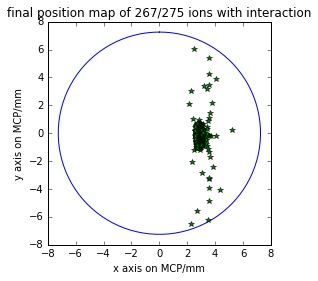

In [63]:
%matplotlib inline
plt.figure()
theta=np.linspace(0,2*np.pi,100)
plt.plot(7.25*np.sin(theta),7.25*np.cos(theta))
plt.axes().set_aspect('equal')
plt.plot(finalpoints_good[:,0],finalpoints_good[:,1],'*')
plt.xlabel("x axis on MCP/mm")
plt.ylabel("y axis on MCP/mm")
#plt.xlim([-8,8])
#plt.ylim([-8,8])
plt.title("final position map of 267/275 ions with interaction")
plt.show()

In [68]:
"""
%matplotlib notebook
newplot=plt.figure()
ionplot=newplot.add_subplot(111,projection='3d')
#mp.plot(MCP[:,0],MCP[:,1],MCP[:,2],label='MCP')
ionplot.plot(startpoints[:,0],startpoints[:,1],startpoints[:,2],'.')
#mp.plot(points[:,0],points[:,1],points[:,2])
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Start point, x:94.45 - 94.55, y:102.49 - 102.51, z:55.49 - 55.51 \n ion distance 5um")
plt.show()
"""

'\n%matplotlib notebook\nnewplot=plt.figure()\nionplot=newplot.add_subplot(111,projection=\'3d\')\n#mp.plot(MCP[:,0],MCP[:,1],MCP[:,2],label=\'MCP\')\nionplot.plot(startpoints[:,0],startpoints[:,1],startpoints[:,2],\'.\')\n#mp.plot(points[:,0],points[:,1],points[:,2])\nplt.xlabel("X")\nplt.ylabel("Y")\nplt.title("Start point, x:94.45 - 94.55, y:102.49 - 102.51, z:55.49 - 55.51 \n ion distance 5um")\nplt.show()\n'

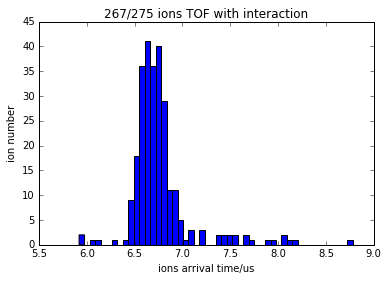

In [71]:
%matplotlib inline
count, bins, ignored = plt.hist(finalpoints_good[:,2], 50)
plt.xlabel("ions arrival time/us")
plt.ylabel("ion number")
plt.title("267/275 ions TOF with interaction")
plt.show()

In [73]:
fions=h5py.File('TOF and final position with Coulombic interaction.hdf5','w')

In [76]:
TOFv2=fions.create_group("new voltage set")

In [78]:
finalcoulv2=TOFv2.create_dataset("final points",(ionfinalpoints.shape),dtype=np.float64)
finalcoulv2[...]=ionfinalpoints

In [79]:
startcoul=TOFv2.create_dataset("startpoints",(startpoints.shape),dtype=np.float64)
startcoul[...]=startpoints

In [237]:
fcoul=h5py.File('TOF and final position with Coulombic interaction.hdf5','w')

In [238]:
startcoul=fcoul.create_dataset("startpoints",(startpoints.shape),dtype=np.float64)

In [265]:
startcoul[...]=startpoints

In [239]:
finalcoul=fcoul.create_dataset("finalpoints",(finalpoints.shape),dtype=np.float64)
finalcoul[...]=finalpoints

In [27]:
fnocoul=h5py.File('TOF and final position without Couloumbic interaction.hdf5','w')

In [28]:
single=fnocoul.create_dataset("single ions final position",(singlefinals.shape),dtype=np.float64)

In [162]:
v0=np.zeros((100,3))
r0=np.zeros((100,3))
for k in range(len(r0)):
    r0[k]=[94.5 + k*0.1,102.5,54.5]
#r0=np.array([[94.5,102.5,54.5],[94.6,102.5,54.5],[94.7,102.5,54.5],[94.8,102.5,54.5]])
tstart=time.time()
r=trajectories_ions(r0,v0,dt)
tend=time.time()
print r,tend-tstart

[[ 0.18829336  0.07690852  4.45376038]
 [ 0.05391135  0.08748673  4.44320879]
 [-0.07262028  0.0979      4.43302534]
 [-0.19288363  0.10811478  4.42307097]
 [-0.30193144  0.11810359  4.41349445]
 [-0.3992394   0.12778341  4.40436299]
 [-0.48707629  0.13710076  4.39575847]
 [-0.56709355  0.14628521  4.38757263]
 [-0.6336089   0.15531062  4.37977038]
 [-0.68683687  0.16414294  4.37236991]
 [-0.719545    0.17271789  4.36547806]
 [-0.73730465  0.18100197  4.35924184]
 [-0.75769785  0.1892606   4.35392753]
 [-0.76707881  0.19739203  4.34897964]
 [-0.78482101  0.20536316  4.34435681]
 [-0.80398912  0.21300716  4.3395068 ]
 [-0.83763186  0.22029878  4.33458917]
 [-0.88079716  0.22740469  4.329504  ]
 [-0.93059264  0.23418254  4.32354854]
 [-0.99867372  0.24077771  4.31781273]
 [-1.07005457  0.24711208  4.31219076]
 [-1.15118889  0.25299205  4.30590794]
 [-1.23979883  0.25881449  4.30018954]
 [-1.32781134  0.2644488   4.29437629]
 [-1.42037083  0.26988538  4.28862454]
 [-1.50727853  0.27515801

### Coulomb interaction influence

In [79]:
#Starting point r0 and initial velocity v0
r0=np.array([94.5,102.5,55.5])
v0=np.array([0,0,0])
[f10,v10]=trajectory2(r0,v0,dt)
f10,v10

([0.27608091170657961, 0.069906204468793476, 4.4917916905373669],
 array([ 62.59098621,   0.063188  ,  12.78745611]))

In [30]:
startpoints

array([[ 131.54740565,  102.44407167,   69.0841234 ],
       [ 131.77244034,  102.44133677,   69.20591509],
       [ 131.72223346,  102.44920812,   69.33141989],
       [ 132.1394517 ,  102.43629769,   69.25020099],
       [ 131.61013551,  102.43943784,   69.32228961],
       [ 131.55388635,  102.45427449,   69.08216192],
       [ 131.77706633,  102.45223878,   69.20669303],
       [ 131.74247704,  102.45757833,   69.33209474],
       [ 131.50538754,  102.45078746,   69.17135498],
       [ 131.60388686,  102.45260613,   69.32229659],
       [ 131.56523307,  102.46440684,   69.08151726],
       [ 131.7865429 ,  102.46290623,   69.20826622],
       [ 131.77456713,  102.46517897,   69.33357249],
       [ 131.51653811,  102.46384088,   69.17109538],
       [ 131.62127936,  102.46292881,   69.32171704],
       [ 131.57899044,  102.47508141,   69.0822531 ],
       [ 131.79813302,  102.47420749,   69.21014075],
       [ 131.81168494,  102.47316692,   69.33562721],
       [ 131.52995084,  102.

In [228]:
xc=np.linspace(94.5 - 0.05,94.5 + 0.05,21)
yc=np.linspace(102.5 - 0.01,102.5 + 0.01,5)
zc=np.linspace(55.5 - 0.01,55.5 + 0.01,5)
print xc
print yc
print zc

[ 94.45   94.455  94.46   94.465  94.47   94.475  94.48   94.485  94.49
  94.495  94.5    94.505  94.51   94.515  94.52   94.525  94.53   94.535
  94.54   94.545  94.55 ]
[ 102.49   102.495  102.5    102.505  102.51 ]
[ 55.49   55.495  55.5    55.505  55.51 ]


In [40]:
r0=np.array([102.5,102.5,65.])
v0=np.array([0.,0.,0.])